# Convolutional Neural Network Mimic CXR

In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
"""activer virtual machine"""

#connect the computer to the Virtual machine
gcloud compute ssh instance-20250304-142251

#connect vm to vscode
whoami  #donne le user
hostname -I # donne l'adresse ip de la vm 10.132.0.2
ssh celiabenay@10.132.0.2   #dans terminal

#dans vscode
cmd+shift+P #- Remote-SSH: Open SSH Configuration File...
#choisis ~/.ssh/config
#add a la fin
Host ma-vm   #vm_project
    HostName adresse_ip_vm  #adress ip exterieure!!
    User ton_user

#puis Ctrl+Shift+P → Remote-SSH: Connect to Host...

#dans le fine ~/.ssh/config input the external ip adress (see google cloud)

git clone git@github.com:celia-be/WAGON_final_project.git #dans le terminal virtual machine pour telecharger github folder

#update git sans devoir re cloner si ca a deja été fait une fois
cd WAGON_final_project
git pull origin main

"""connecter git sur une nouvelle vm"""
ssh-keygen -t ed25519 -C "runpod-vm"  #puis enter, enter, enter

cat ~/.ssh/id_ed25519.pub  #copier le resultat

'''3. 🔗 Colle-la sur GitHub
Va sur https://github.com/settings/keys
Clique sur New SSH key
Donne-lui un nom (ex: runpod-vm)
Colle ta clé publique dans le champ
Clique sur Add SSH key'''   #allow write!!!!!

ssh -T git@github.com  #test que ca fonctionne


---
## 1. LOAD DATA

In [2]:
'''This Dataset contains about 5000 pictures of cats and dogs
(4000 for training and 1000 for testing). Each category will
be in a separated folder, `cat-and-dog/training_set/` and
`cat-and-dog/test_set` and then in sub folders `cats` and `dogs`.'''

# Let's store the location of our data in 2 variables that we can re use later
train_data_dir = "/Users/celiabenay/code/celia-be/WAGON_final_project/label_extraction/split_extracted_label_10000/train"
val_data_dir ="/Users/celiabenay/code/celia-be/WAGON_final_project/label_extraction/split_extracted_label_10000/val"
test_data_dir="/Users/celiabenay/code/celia-be/WAGON_final_project/label_extraction/split_extracted_label_10000/test"

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
# img = load_img(f"{train_data_dir}cats/cat.3.jpg")
# x = img_to_array(img)/255  # We divide the pixel value by 255 to end up between 0 and 1


---
## 2. CREATE TENSORFLOW DATASET

In [6]:
'''Here, we'll create a `Tensorflow Datasets` object.
This will allow us to:
*   Grab images from our directory batch by batch,
we won't load ALL the data at the same time
*   Reshape all the images to our desired input shape,
150x150 in this recap'''
batch_size = 64

train_ds = image_dataset_from_directory(
    train_data_dir,   #where the data is located
    labels="inferred",  #labels inferred based on the folder structure
    label_mode="categorical", #cat=0 dog=1
    seed=123,
    image_size=(512, 512),   #target size to resize our images to fit the model, adapt according tot he model!!
    batch_size=batch_size)  #batch size

# We define a second one for the test data

val_ds = image_dataset_from_directory(
    val_data_dir,
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(512, 512), #(150, 150),
    batch_size=batch_size)


class_names = train_ds.class_names
print(class_names)

Found 4474 files belonging to 8 classes.
Found 1277 files belonging to 8 classes.
['aortic_calcification', 'atelectasis', 'cardiomegaly', 'no_abnormality', 'opacity', 'pleural_effusion', 'pneumothorax', 'pulmonary_edema']


---
## 3. DATA AUGMENTATION


In [7]:
data_augmentation = Sequential() #create a data augmentation layer for the model

data_augmentation.add(layers.RandomFlip("horizontal"))
data_augmentation.add(layers.RandomZoom(0.1))
data_augmentation.add(layers.RandomTranslation(0.2, 0.2))
data_augmentation.add(layers.RandomRotation(0.1))


---
## 4. FINE TUNING


In [8]:
#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.models import Model

base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(512, 512, 3))  #adapt input_shape en fonction de ce qu'on a défini plus haut!

# First step is to initialize the VGG16 model but without the top as we'll adapt it to our problem
inputs = layers.Input(shape=(512, 512, 3))

x = data_augmentation(inputs) # We still have our data augmentation layers
x = preprocess_input(x) # Then a preprocessing layer specifically designed for the VGG16
x = base_model(x) # Then our transfer learning model

x = layers.Flatten()(x) # Followed by our custom dense layers, tailored to our binary task

x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)
pred = layers.Dense(8, activation="softmax")(x)

# We use the keras Functional API to create our keras model

model_3 = Model(inputs=inputs , outputs=pred)

#FOR FINETUNING:
# And we freeze the VGG16 model
base_model.trainable = False

# for layer in base_model.layers[:10]:
#     layer.trainable = False

---
## 5. COMPILE

In [9]:
adam = optimizers.Adam(learning_rate=0.001)
model_3.compile(loss='categorical_crossentropy',
                optimizer=adam,
                metrics=['accuracy'])

---
## 6. CALLBACKS

In [10]:
'''Those functions will be called at the end of every single epoch.
We'll use:


*   `ModelCheckpoint` to save the best version of our model after every epoch
*   `ReduceLROnPlateau` to reduce the `learning_rate` if the model doesn't get better after a few epochs
*   `EarlyStopping` to stop the training after a certain time if it's not improving'''

MODEL = "model_3.keras"

modelCheckpoint = callbacks.ModelCheckpoint(MODEL,   #save best version after each epochs
                                            monitor="val_loss",
                                            verbose=0,
                                            save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", #reduce lr if model doesn't get better after few epochs
                                        factor=0.1,
                                        patience=3,
                                        verbose=1,
                                        min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss',
                                       patience=10,
                                       verbose=0,
                                       restore_best_weights=True)


---
## 7. FIT

In [11]:
history_3 = model_3.fit(
        train_ds,
        epochs=20,
        validation_data=val_ds,
        callbacks = [modelCheckpoint, LRreducer, EarlyStopper])


Epoch 1/20
53/70 ━━━━━━━━━━━━━━━━━━━━ 1:48 6s/step - accuracy: 0.1555 - loss: 10.7191

KeyboardInterrupt: 

---
## 8. PLOT MODEL AND COMPARE

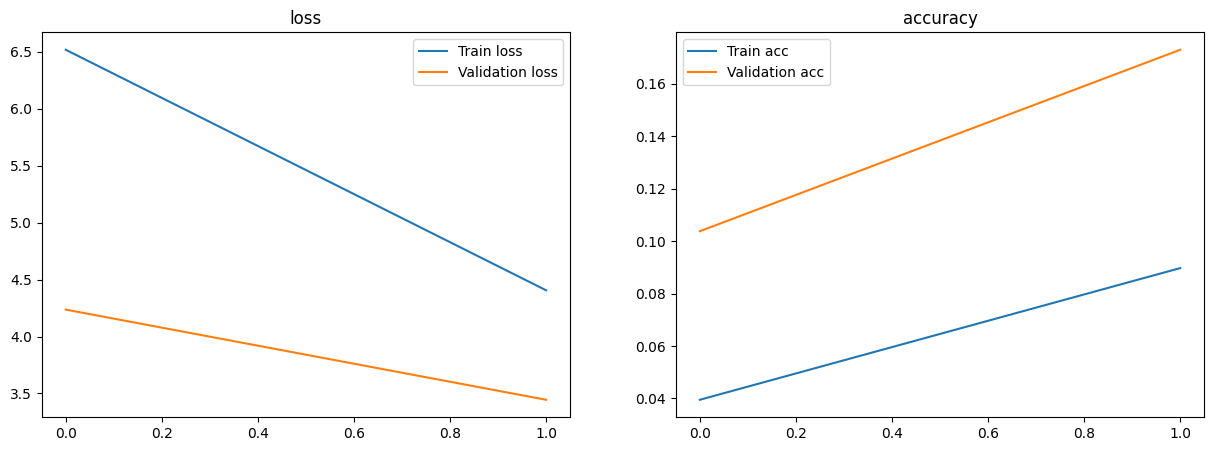

In [30]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

def plot_compare_history(history, name_history, history_1, name_history_1):

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].set_title('loss')

    ax[0].plot(history.epoch, history.history["loss"], label="Train loss " + name_history)
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss " + name_history)

    ax[0].plot(history_1.epoch, history_1.history["loss"], label="Train loss " + name_history_1)
    ax[0].plot(history_1.epoch, history_1.history["val_loss"], label="Validation loss " + name_history_1)

    ax[1].set_title('Accuracy')

    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy " + name_history)
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy " + name_history)

    ax[1].plot(history_1.epoch, history_1.history["accuracy"], label="Train Accuracy " + name_history_1)
    ax[1].plot(history_1.epoch, history_1.history["val_accuracy"], label="Validation Accuracy " + name_history_1)

    ax[0].legend()
    ax[1].legend()

plot_history(history_3)
#plot_compare_history(history, "Basic CNN", history_3, "Transfer Learning")


---
## 9. SAVE AND USE THE MODEL



In [ ]:
#save
model_3.save("model_3.keras")

#load
from tensorflow.keras.models import load_model

model_3 = load_model("model_3.keras")

---
## 10. USE THE MODEL

In [ ]:
from PIL import Image
import requests
from io import BytesIO

def getImage(url):
    '''Grabs an image based on its URL, and resize it
    '''
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    img = img.resize((150, 150))
    return img

def predictImage(url, model):
    '''Takes an image and a model
    '''
    img = getImage(url)
    img = img_to_array(img)
    img = img.reshape((-1, 150, 150, 3))
    res = model.predict(img)[0][0]
    if(res < 0.5):
        animal = "cat"
        prob = 1-res
    if(res >= 0.5):
        animal = "dog"
        prob = res

    print("Animal : ", animal)
    print("probability = ",prob)

cat = "https://www.wikichat.fr/wp-content/uploads/sites/2/comment-soigner-une-plaie-dun-chat.jpg"
cat2 = "http://create.votreveterinaire.com/adm/webmaster/_empty/upload/chat_surpris.jpg"

dog = "https://images.sudouest.fr/2018/04/14/5ace461a66a4bd2b1780a0dd/widescreen/1000x500/on-ignore-si-le-chihuahua-a-deserte-ou-non-les-locaux-de-la-clinique.jpg?v1"
dog2 = "https://ds1.static.rtbf.be/article/image/370x208/7/8/f/a20f02dfccd07952da54a7f9a82b3e89-1524657315.jpg"

predictImage(cat, model_3)
predictImage(dog, model_3)